# Objectives

1. Plot Subtrees: Phylo
1. Plot Subtrees: Map

---
# Setup

## Imports

In [1]:
import os
import dill
from Bio import Phylo
import copy

import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from pyproj import Proj, transform
import math

## Variables

In [2]:
from config import *

# Custom script variables
SCRIPT_NAME = "geo"
PREV_DIR_NAME = "mugration"
PREV_SCRIPT_NAME = "mugration_model"

try:
    WILDCARDS = snakemake.wildcards
    project_dir = os.getcwd()
except NameError:
    WILDCARDS = ["all", "chromosome", "50"]
    project_dir = os.path.dirname(os.path.dirname(os.getcwd()))
    
READS_ORIGIN = WILDCARDS[0]
LOCUS_NAME = WILDCARDS[1]
MISSING_DATA = WILDCARDS[2]

NAME_COL = "Name"

GEO_ATTR = "Mugration_Province"
PLOT_ATTR = "Mugration_Branch_Number"
COL_ATTR = "Mugration_Branch_Major"

## File Paths

In [3]:
results_dir = os.path.join(project_dir, "results")
config_dir = os.path.join(results_dir, "config")


outdir       = os.path.join(results_dir, SCRIPT_NAME, READS_ORIGIN, LOCUS_NAME + "_filter{}".format(MISSING_DATA),)
tree_dill    = os.path.join(results_dir, PREV_DIR_NAME, READS_ORIGIN, LOCUS_NAME + "_filter{}".format(MISSING_DATA),PREV_SCRIPT_NAME + "_timetree.treetime.obj")
tree_df_dill = os.path.join(results_dir, PREV_DIR_NAME, READS_ORIGIN, LOCUS_NAME + "_filter{}".format(MISSING_DATA), PREV_SCRIPT_NAME + ".df.obj")
tree_df_path = os.path.join(results_dir, PREV_DIR_NAME, READS_ORIGIN, LOCUS_NAME + "_filter{}".format(MISSING_DATA), PREV_SCRIPT_NAME + ".tsv")
aln_path     = os.path.join(results_dir,"snippy_multi",READS_ORIGIN,"snippy-core_{}.snps.filter{}.aln".format(LOCUS_NAME, MISSING_DATA))

# Auspice
auspice_latlon_path = os.path.join(results_dir, "parse_tree", READS_ORIGIN, LOCUS_NAME + "_filter{}".format(MISSING_DATA), "parse_tree" + "_latlon.tsv")
auspice_colors_path = os.path.join(results_dir, "parse_tree", READS_ORIGIN, LOCUS_NAME + "_filter{}".format(MISSING_DATA), "parse_tree" + "_colors.tsv")
auspice_config_path = os.path.join(config_dir, "auspice_config.json")
auspice_remote_dir_path = os.path.join(project_dir, "auspice/")

print("tree_dill:\t", tree_dill)
print("tree_df_dill:\t", tree_df_dill)
print("aln path:\t", aln_path)
print("auspice_latlon_path:", auspice_latlon_path)
print("auspice_colors_path:", auspice_colors_path)
print("auspice_config_path:", auspice_config_path)
print("auspice_remote_dir_path:", auspice_remote_dir_path)
print("outdir:", outdir)

# Create output directory if it doesn't exist
while not os.path.exists(outdir):
    os.makedirs(outdir)   
    
SCRIPT_NAME = "geo"

tree_dill:	 /mnt/c/Users/ktmea/Projects/plague-phylogeography/results/mugration/all/chromosome_filter50/mugration_model_timetree.treetime.obj
tree_df_dill:	 /mnt/c/Users/ktmea/Projects/plague-phylogeography/results/mugration/all/chromosome_filter50/mugration_model.df.obj
aln path:	 /mnt/c/Users/ktmea/Projects/plague-phylogeography/results/snippy_multi/all/snippy-core_chromosome.snps.filter50.aln
auspice_latlon_path: /mnt/c/Users/ktmea/Projects/plague-phylogeography/results/parse_tree/all/chromosome_filter50/parse_tree_latlon.tsv
auspice_colors_path: /mnt/c/Users/ktmea/Projects/plague-phylogeography/results/parse_tree/all/chromosome_filter50/parse_tree_colors.tsv
auspice_config_path: /mnt/c/Users/ktmea/Projects/plague-phylogeography/config/auspice_config.json
auspice_remote_dir_path: /mnt/c/Users/ktmea/Projects/plague-phylogeography/auspice/
outdir: /mnt/c/Users/ktmea/Projects/plague-phylogeography/results/geo/all/chromosome_filter50


## Import Tree

In [4]:
with open(tree_dill, "rb") as infile:
    tt = dill.load(infile)
tt.tree.ladderize(reverse=False)

## Import Dataframe

In [5]:
with open(tree_df_dill, "rb") as infile:
    tree_df = dill.load(infile)
display(tree_df)

,UFboot,sCF,Branch_Length,Branch_Support_Color,coord_x,coord_y,Strain,Date,DateBP,Country,Province,CountryLat,CountryLon,ProvinceLat,ProvinceLon,Biovar,Branch_Major,Branch_Minor,BioSample,BioSampleComment,Branch_Number,timetree_rate,timetree_rate_fold_change,timetree_mutation_length,timetree_raw_date,timetree_num_date,timetree_num_date_confidence,timetree_num_date_bar,timetree_clock_length,timetree_coord_x,timetree_coord_y,timetree_reg_x,timetree_reg_y,timetree_reg_bad,Mugration_Branch_Number,Mugration_Branch_Number_Confidence,Mugration_Branch_Number_Entropy,Mugration_Branch_Major,Mugration_Branch_Major_Confidence,Mugration_Branch_Major_Entropy,Mugration_Branch_Minor,Mugration_Branch_Minor_Confidence,Mugration_Branch_Minor_Entropy,Mugration_Country,Mugration_Country_Confidence,Mugration_Country_Entropy,Mugration_Country_Lat,Mugration_Country_Lon,Mugration_Province,Mugration_Province_Confidence,Mugration_Province_Entropy,Mugration_Province_Lat,Mugration_Province_Lon
Name,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
NODE0,NA,NA,0.000000e+00,black,2.148815e-07,2.25,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,1.942141e-08,1.000000,2.148815e-07,0855-09-28,855.740923,"[855.7409234792349, 855.7409234792349]","[1165.2590765207651, 1165.2590765207651]",0.100000,0.100000,2.25,855.740923,0.000000,False,1,0.379404,1.08856,1.ORI,0.379404,1.08856,1.ORI1,0.379404,1.08856,Russia,0.379404,1.08856,64.6863,97.7453,Rostov Oblast,0.379404,1.08856,47.6222,40.7958
GCA_009909635.1_ASM990963v1_genomic,NA,NA,2.447080e-05,grey,2.278202e-05,1.00,9_10,1923,-98,Russia,Rostov Oblast,64.6863,97.7453,47.6222,40.7958,Medievalis,2.MED,2.MED1,SAMN13632815,KEEP: Assembly Modern,2,2.052208e-08,1.056673,2.256714e-05,1938-03-30,1938.242634,"[1923.0, 1923.0]","[98.0, 98.0]",1082.501711,1082.601711,1.00,1923.000000,0.000023,False,2,1,-1.00009e-12,2.MED,1,-1.00009e-12,2.MED1,1,-1.00009e-12,Russia,1,-1.00009e-12,64.6863,97.7453,Rostov Oblast,1,-1.00009e-12,47.6222,40.7958
Reference,NA,NA,2.307300e-05,grey,2.149205e-05,2.00,NA,1992,-29,United States of America,Colorado,39.7837,-100.446,38.7252,-105.608,Orientalis,1.ORI,1.ORI1,NA,KEEP: Assembly Modern Reference,1,1.821491e-08,0.937878,2.127716e-05,1996-07-12,1996.529295,"[1992.0, 1992.0]","[29.0, 29.0]",1140.788371,1140.888371,2.00,1992.000000,0.000021,False,1,1,-1.00009e-12,1.ORI,1,-1.00009e-12,1.ORI1,1,-1.00009e-12,United States of America,1,-1.00009e-12,39.7837,-100.446,Colorado,1,-1.00009e-12,38.7252,-105.608
NODE1,91,0,2.721210e-05,black,2.536025e-05,3.50,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,2.136642e-08,1.100148,2.514537e-05,2005-09-05,2005.678813,"[1985.457689492314, 2005.0]","[35.5423105076859, 16.0]",1149.937889,1150.037889,3.50,2005.678813,0.000025,False,0,0.875959,0.460385,0.ANT,0.875959,0.460385,0.ANT1,0.875959,0.460385,China,0.875959,0.460385,35.0001,105,Xinjiang,0.875959,0.460385,42.4805,85.4633
GCA_009669545.1_ASM966954v1_genomic,NA,NA,2.330000e-08,grey,2.536025e-05,3.00,42126,2006,-15,China,Xinjiang,35.0001,105,42.4805,85.4633,Antiqua,0.ANT,0.ANT1,SAMN07722925,KEEP: Assembly Modern,0,5.812589e-09,0.299288,2.828252e-18,2008-05-10,2008.355574,"[2006.0, 2006.0]","[15.0, 15.0]",2.676761,1152.714650,3.00,2006.000000,0.000025,False,0,1,-9.99867e-13,0.ANT,1,-9.99867e-13,0.ANT1,1,-9.99867e-13,China,1,-1.00009e-12,35.0001,105,Xinjiang,1,-1.00009e-12,42.4805,85.4633
GCA_009669555.1_ASM966955v1_genomic,NA,NA,2.331000e-07,grey,2.557514e-05,4.00,42123,2005,-16,China,Xinjiang,35.0001,105,42.4805,85.4633,Antiqua,0.ANT,0.ANT1,SAMN07722924,KEEP: Assembly Modern,0,3.247561e-08,1.672155,2.148899e-07,2007-07-06,2007.510839,"[2005.0, 2005.0]","[16.0, 16.0]",1.832026,1151.869916,4.00,2005.000000,0.000025,False,0,1,-9.99867e-13,0.ANT,1,-9.99867e-13,0.ANT1,1,-9.99867e-13,China,1,-1.00009e-12,35.0001,105,Xinjiang,1,-1.00009e-12,42.4805,85.4633


In [6]:
# Remove Bad Samples

# CDC : GCA_002529545.1_ASM252954v1_genomic
# Drop CDC Sample: GCA_002529545.1_ASM252954v1_genomic
if "GCA_002529545.1_ASM252954v1_genomic" in [t.name for t in tt.tree.get_terminals()]:
    node = tt.tree.common_ancestor("GCA_002529545.1_ASM252954v1_genomic")
    parent = node.up
    tt.tree.prune(node)
    tree_df.drop(node.name, inplace=True)
    tree_df.drop(parent.name, inplace=True)

## Convert Dataframe to Geopandas

In [7]:
geometry = []
for rec in tree_df.iterrows():
    sample = rec[0]
    geo_attr = "Province"
    # 1) Is this a tip?
    if rec[1]["Branch_Support_Color"] == TERM_COL:
        # 2) Does this tip have province data?
        if rec[1]["Province"] == NO_DATA_CHAR and rec[1]["Country"] != "Russia":
            geo_attr = "Country"
    x,y = tree_df["Mugration_" + geo_attr + "_Lon"][sample], tree_df["Mugration_" + geo_attr + "_Lat"][sample]
    geometry.append(shapely.geometry.Point(x,y))
    
tree_gdf = geopandas.GeoDataFrame(tree_df, crs=CRS, geometry=geometry)
display(tree_gdf)

,UFboot,sCF,Branch_Length,Branch_Support_Color,coord_x,coord_y,Strain,Date,DateBP,Country,Province,CountryLat,CountryLon,ProvinceLat,ProvinceLon,Biovar,Branch_Major,Branch_Minor,BioSample,BioSampleComment,Branch_Number,timetree_rate,timetree_rate_fold_change,timetree_mutation_length,timetree_raw_date,timetree_num_date,timetree_num_date_confidence,timetree_num_date_bar,timetree_clock_length,timetree_coord_x,timetree_coord_y,timetree_reg_x,timetree_reg_y,timetree_reg_bad,Mugration_Branch_Number,Mugration_Branch_Number_Confidence,Mugration_Branch_Number_Entropy,Mugration_Branch_Major,Mugration_Branch_Major_Confidence,Mugration_Branch_Major_Entropy,Mugration_Branch_Minor,Mugration_Branch_Minor_Confidence,Mugration_Branch_Minor_Entropy,Mugration_Country,Mugration_Country_Confidence,Mugration_Country_Entropy,Mugration_Country_Lat,Mugration_Country_Lon,Mugration_Province,Mugration_Province_Confidence,Mugration_Province_Entropy,Mugration_Province_Lat,Mugration_Province_Lon,geometry
Name,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
NODE0,NA,NA,0.000000e+00,black,2.148815e-07,2.25,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,1.942141e-08,1.000000,2.148815e-07,0855-09-28,855.740923,"[855.7409234792349, 855.7409234792349]","[1165.2590765207651, 1165.2590765207651]",0.100000,0.100000,2.25,855.740923,0.000000,False,1,0.379404,1.08856,1.ORI,0.379404,1.08856,1.ORI1,0.379404,1.08856,Russia,0.379404,1.08856,64.6863,97.7453,Rostov Oblast,0.379404,1.08856,47.6222,40.7958,POINT (40.79579 47.62225)
GCA_009909635.1_ASM990963v1_genomic,NA,NA,2.447080e-05,grey,2.278202e-05,1.00,9_10,1923,-98,Russia,Rostov Oblast,64.6863,97.7453,47.6222,40.7958,Medievalis,2.MED,2.MED1,SAMN13632815,KEEP: Assembly Modern,2,2.052208e-08,1.056673,2.256714e-05,1938-03-30,1938.242634,"[1923.0, 1923.0]","[98.0, 98.0]",1082.501711,1082.601711,1.00,1923.000000,0.000023,False,2,1,-1.00009e-12,2.MED,1,-1.00009e-12,2.MED1,1,-1.00009e-12,Russia,1,-1.00009e-12,64.6863,97.7453,Rostov Oblast,1,-1.00009e-12,47.6222,40.7958,POINT (40.79579 47.62225)
Reference,NA,NA,2.307300e-05,grey,2.149205e-05,2.00,NA,1992,-29,United States of America,Colorado,39.7837,-100.446,38.7252,-105.608,Orientalis,1.ORI,1.ORI1,NA,KEEP: Assembly Modern Reference,1,1.821491e-08,0.937878,2.127716e-05,1996-07-12,1996.529295,"[1992.0, 1992.0]","[29.0, 29.0]",1140.788371,1140.888371,2.00,1992.000000,0.000021,False,1,1,-1.00009e-12,1.ORI,1,-1.00009e-12,1.ORI1,1,-1.00009e-12,United States of America,1,-1.00009e-12,39.7837,-100.446,Colorado,1,-1.00009e-12,38.7252,-105.608,POINT (-105.60772 38.72518)
NODE1,91,0,2.721210e-05,black,2.536025e-05,3.50,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,2.136642e-08,1.100148,2.514537e-05,2005-09-05,2005.678813,"[1985.457689492314, 2005.0]","[35.5423105076859, 16.0]",1149.937889,1150.037889,3.50,2005.678813,0.000025,False,0,0.875959,0.460385,0.ANT,0.875959,0.460385,0.ANT1,0.875959,0.460385,China,0.875959,0.460385,35.0001,105,Xinjiang,0.875959,0.460385,42.4805,85.4633,POINT (85.46335 42.48050)
GCA_009669545.1_ASM966954v1_genomic,NA,NA,2.330000e-08,grey,2.536025e-05,3.00,42126,2006,-15,China,Xinjiang,35.0001,105,42.4805,85.4633,Antiqua,0.ANT,0.ANT1,SAMN07722925,KEEP: Assembly Modern,0,5.812589e-09,0.299288,2.828252e-18,2008-05-10,2008.355574,"[2006.0, 2006.0]","[15.0, 15.0]",2.676761,1152.714650,3.00,2006.000000,0.000025,False,0,1,-9.99867e-13,0.ANT,1,-9.99867e-13,0.ANT1,1,-9.99867e-13,China,1,-1.00009e-12,35.0001,105,Xinjiang,1,-1.00009e-12,42.4805,85.4633,POINT (85.46335 42.48050)
GCA_009669555.1_ASM966955v1_genomic,NA,NA,2.331000e-07,grey,2.557514e-05,4.00,42123,2005,-16,China,Xinjiang,35.0001,105,42.4805,85.4633,Antiqua,0.ANT,0.ANT1,SAMN07722924,KEEP: Assembly Modern,0,3.247561e-08,1.672155,2.148899e-07,2007-07-06,2007.510839,"[2005.0, 2005.0]","[16.0, 16.0]",1.832026,1151.869916,4.00,2005.000000,0.000025,False,0,1,-9.99867e-13,0.ANT,1,-9.99867e-13,0.ANT1,1,-9.99867e-13,China,1,-1.00009e-12,35.0001,105,Xinjiang,1,-1.00009e-12,42.4805,85.4633,POINT (85.46335 42.48050)


# Import Colors

In [8]:
colors_df = pd.read_csv(auspice_colors_path, sep='\t', header=None)
colors_df.columns = ["Attribute", "State", "Color"]
colors_df.fillna(NO_DATA_CHAR, inplace=True)
display(colors_df)

colors_dict = {}
# Convert to dict

for rec in colors_df.iterrows():
    attr = rec[1]["Attribute"]
    state = rec[1]["State"]
    color = rec[1]["Color"]
    if attr not in colors_dict:
        colors_dict[attr] = {}
    colors_dict[attr][state] = color

,Attribute,State,Color
0,branch_number,2.0,#8000ff
1,branch_number,1,#80ffb4
2,branch_number,0.0,#ff0000
3,branch_major,2.MED,#8000ff
4,branch_major,1.ORI,#80ffb4
...,...,...,...
10,country,United States of America,#80ffb4
11,country,China,#ff0000
12,province,Rostov Oblast,#8000ff
13,province,Colorado,#80ffb4


---
# 1. Plot Subtrees: Phylogeny

## Calculate Size by Location

In [9]:
tip_gdf = tree_gdf[tree_gdf["Branch_Support_Color"] == TERM_COL]

# Sizes
marker_scale = 2
marker_size = 20
geom_sizes = {}
tt_copy = copy.deepcopy(tt)
for t in tt_copy.tree.get_terminals():
    geometry = str(tree_gdf["geometry"][t.name])
    if geometry not in geom_sizes:
        geom_sizes[geometry] = 1
    else:
        geom_sizes[geometry] += 1

## Construct

In [10]:
tt_copy = copy.deepcopy(tt)


branch_dict = {
    key : {
        "clade" : None,
        "gdf"   : None,
    } 
    for key in colors_dict["branch_major"].keys()}

for branch in branch_dict:
    #if branch != "1.ANT": continue
    print("Working on branch:", branch)
    target_gdf = copy.deepcopy(tree_gdf)    
    target_nodes = tree_gdf[tree_gdf["Mugration_Branch_Major"] == branch]
    # Add one level up to target nodes    
    target_mrca = tt_copy.tree.common_ancestor(target_nodes.index).up
    # If there's actually an upper node
    if target_mrca:
        mrca_rec = target_gdf[target_gdf.index.str.contains(target_mrca.name)]
        target_nodes = target_nodes.append(mrca_rec)
    # else reset to lower
    else:
        target_mrca = tt_copy.tree.common_ancestor(target_nodes.index)
    target_clade = copy.deepcopy(target_mrca)

    # Create a filtered df
    for rec in tree_df.iterrows():
        sample = rec[0]
        if sample not in target_nodes.index:
            target_gdf.drop(sample, inplace=True)
    branch_dict[branch]["gdf"] = target_gdf

    # Search for the nodes, finding tips to prune
    for c in target_mrca.find_clades(order="postorder"):
        cur_term = [t.name for t in target_clade.get_terminals()]    
        if c.name not in target_nodes.index:
            if c.name in cur_term:
                target_clade.collapse(target=c.name)
                
    # Color branches
    for c in target_clade.find_clades():
        state = tree_df["Mugration_Branch_Major"][c.name]
        color = colors_dict["branch_major"][state]
        c.color = color

    # Assign the sub tree to the dict
    branch_dict[branch]["clade"] = target_clade

Working on branch: 2.MED
Working on branch: 1.ORI
Working on branch: 0.ANT


## Plot

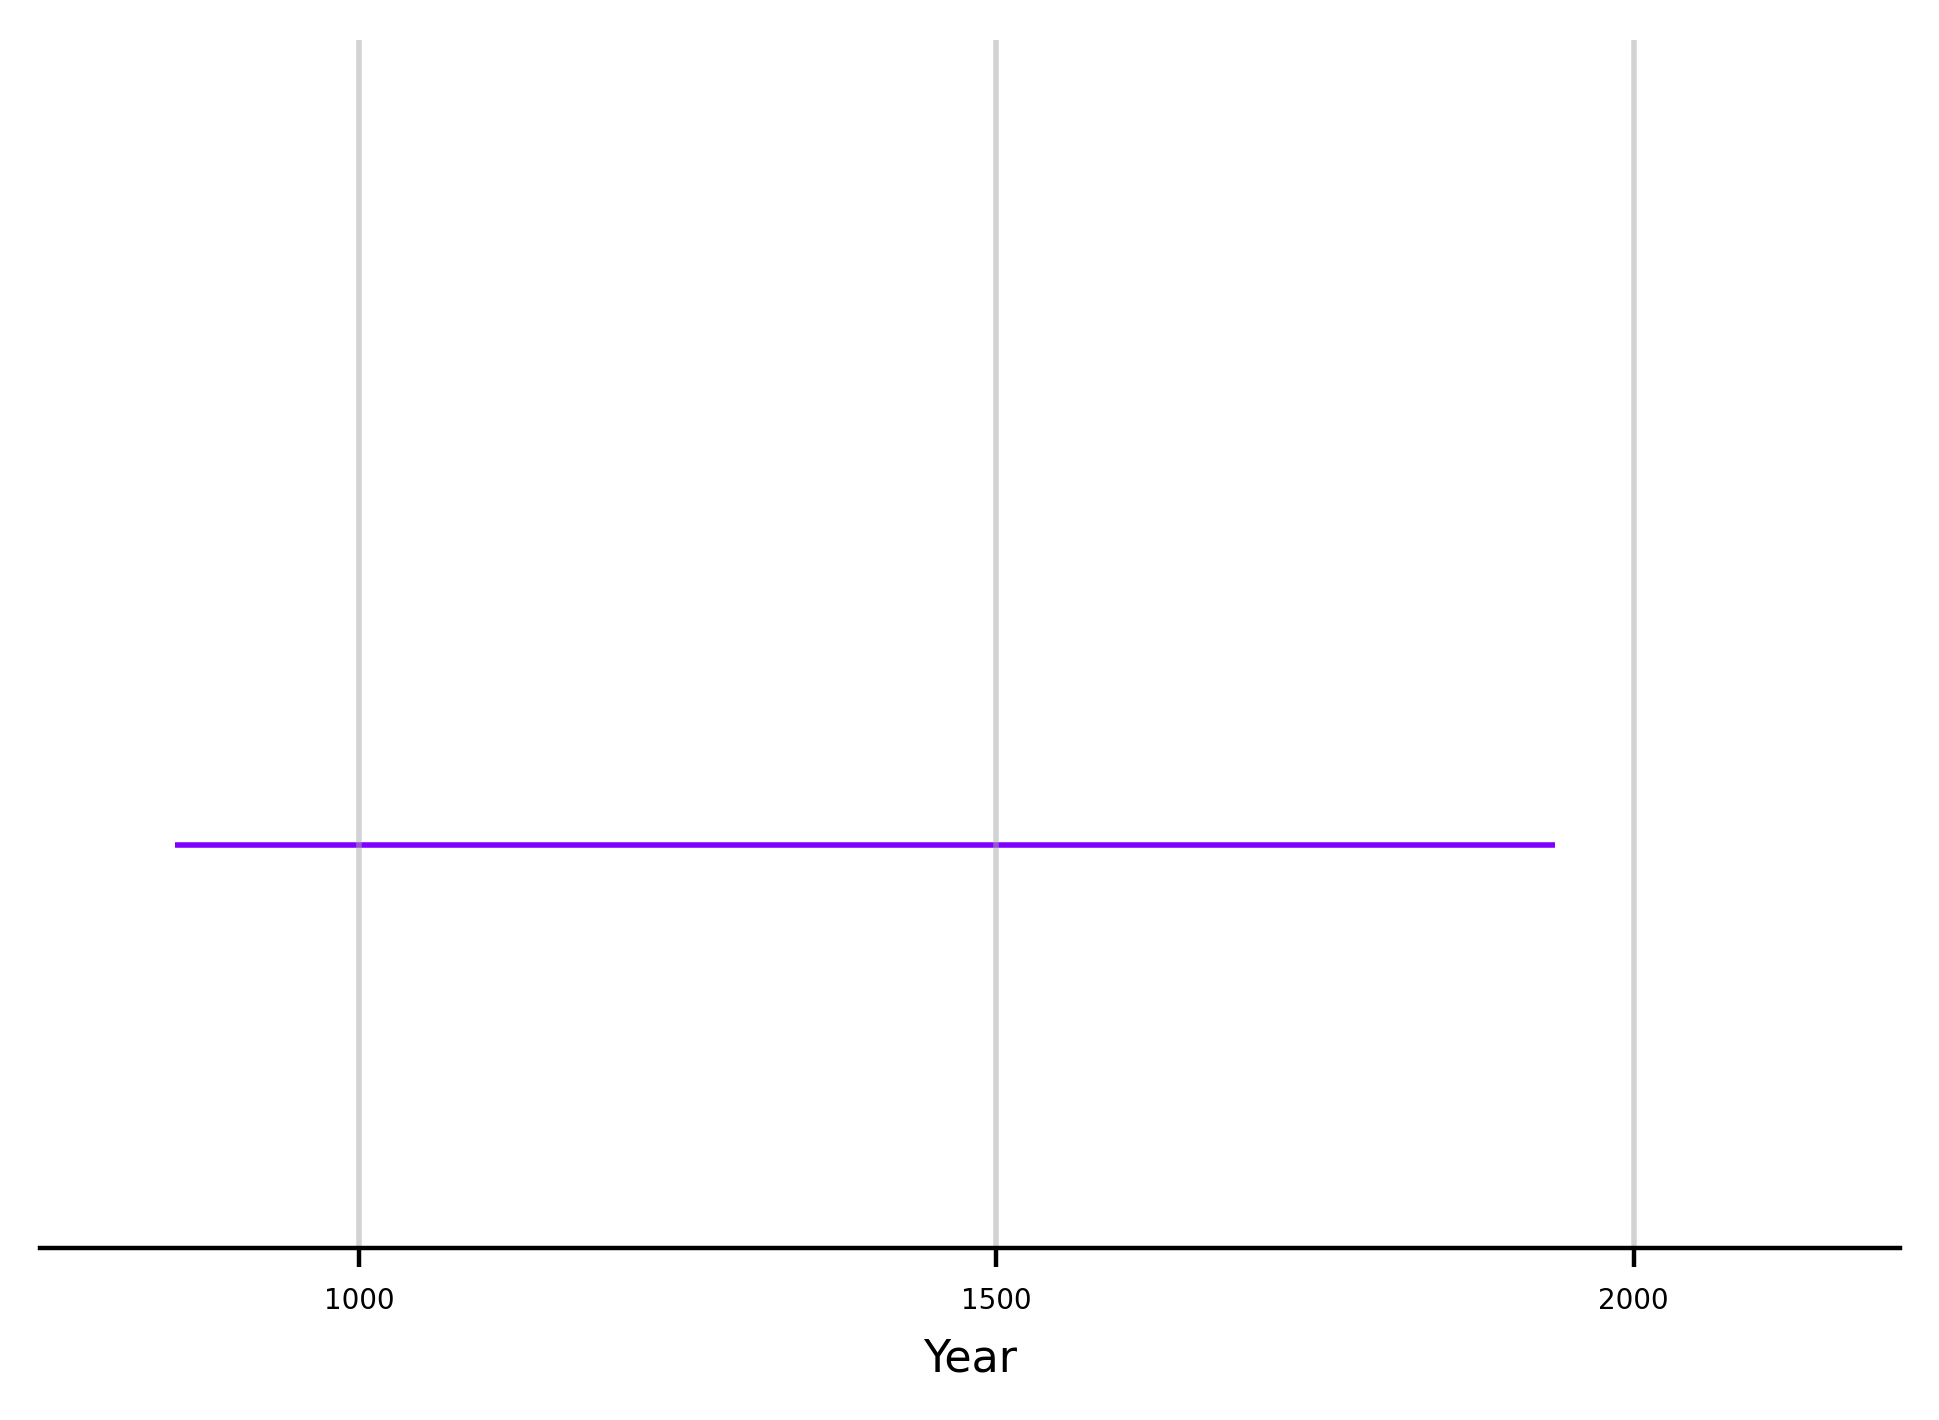

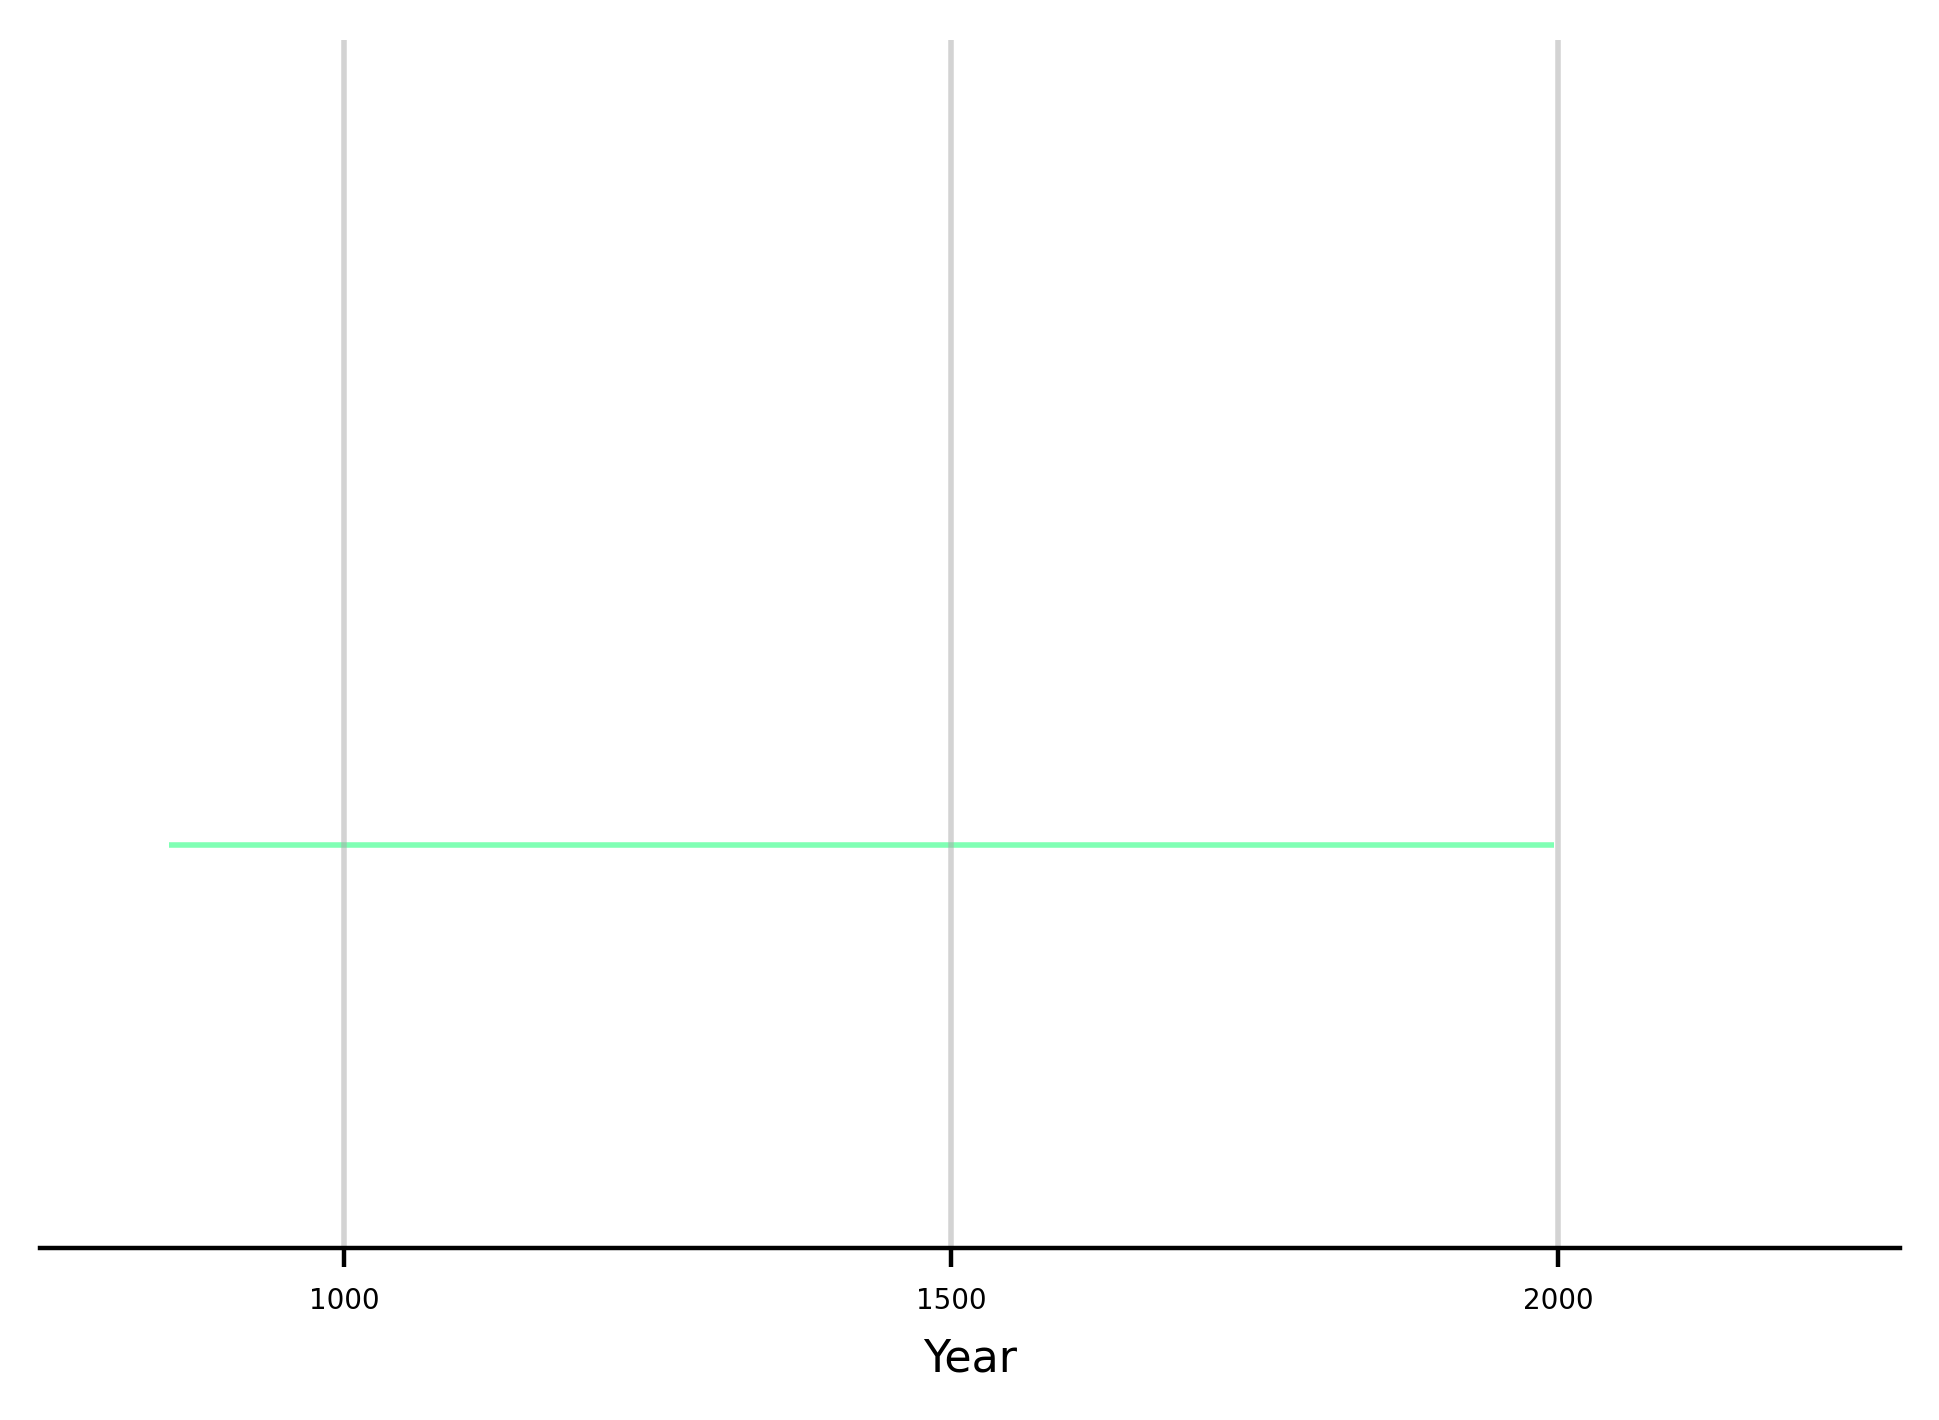

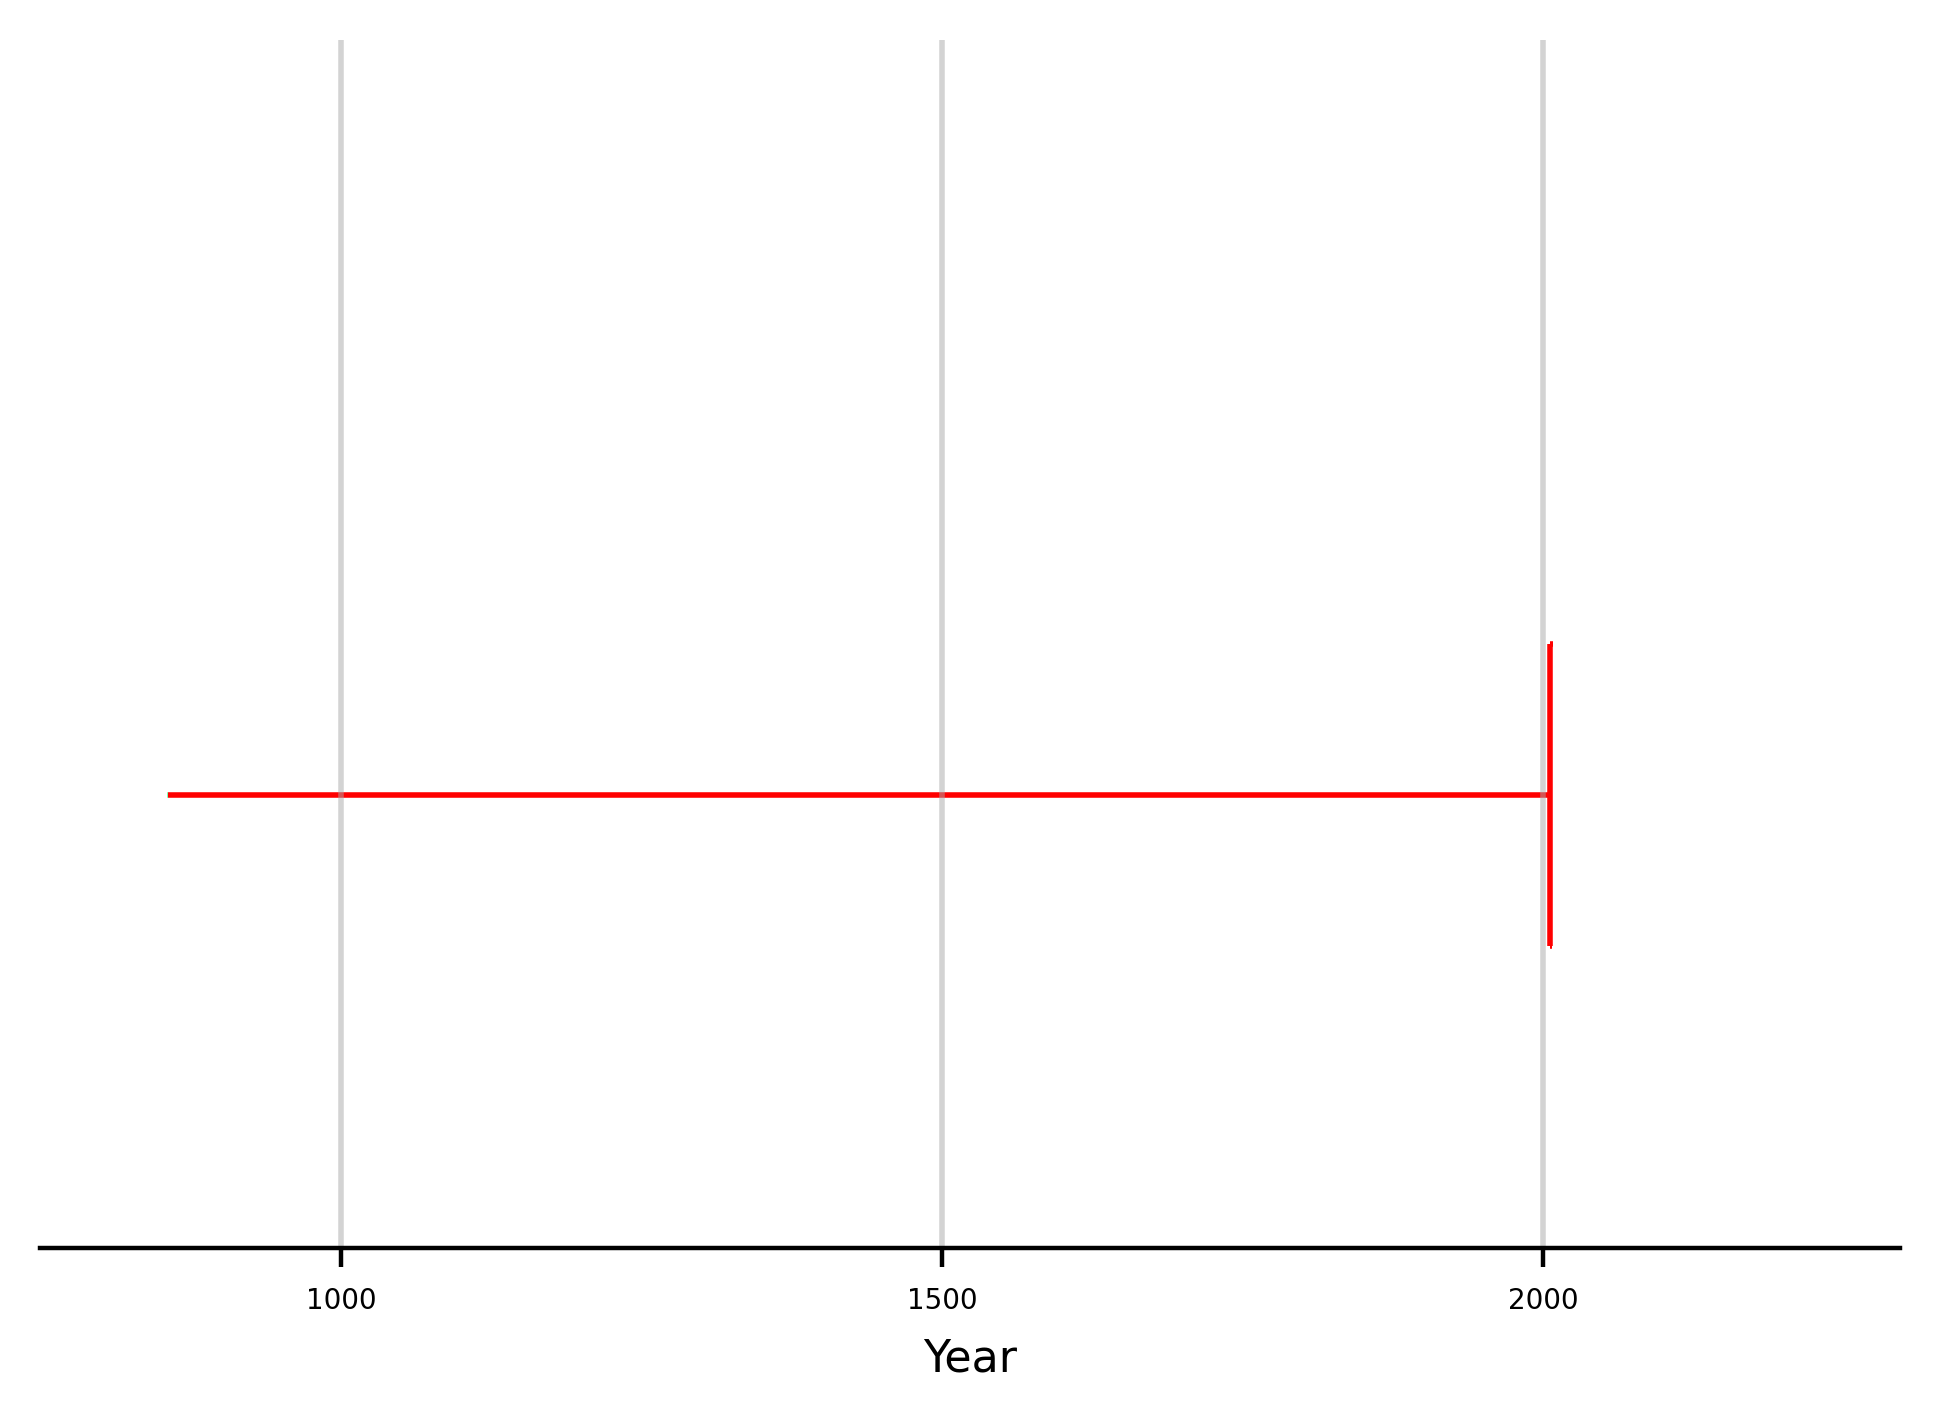

In [11]:
for branch in branch_dict:
    #if branch != "0.ANT" : continue
    tree = branch_dict[branch]["clade"]
    gdf = branch_dict[branch]["gdf"]
    fig, ax1 = plt.subplots(1, dpi=dpi)
    
    if len(tree.get_terminals()) < 50:
        plt.rc("lines", linewidth=1)
    else:
        plt.rc("lines", linewidth=0.5)
        
    Phylo.draw(tree,
                 axes=ax1,
                 show_confidence=False, 
                 #label_func = (lambda x: "{} ({})".format(
                 #        tree_gdf["Strain"][x.name] + " ", 
                 #        tree_gdf["Country"][x.name]) 
                 #    if x.is_terminal() else ''),
                 label_func = lambda x: '',
                 do_show=False,
                )
    
    ax1.set_title("")
    ax1.set_ylabel("")
    ax1.set_yticks([])
    ax1.set_xlabel("Year")
    # --------------------------------------------
    # Ticks
    ticks_dict = convert_timetree_ticks(tree=tree, step=500)
    # Set the new tick locations and labels
    # Leave out last one
    ax1.set_xticks(ticks_dict["tick_locs"][:])
    ax1.set_xticklabels(ticks_dict["tick_labels"][:])

    # --------------------------------------------
    # Lines
    # Vertical lines for dates
    for loc in ticks_dict["tick_locs"][:]:
        ax1.axvline(x=loc, color="darkgrey", alpha=0.5)
        
    x_buffer = math.ceil((ticks_dict["tick_locs"][-1] - ticks_dict["tick_locs"][0]) * 0.07)
    y_buffer = math.ceil(len(tree.get_terminals()) * 0.01)

    ax1.set_xlim(0 - x_buffer,)    
    ax1.set_ylim(len(tree.get_terminals()) + y_buffer, 0 - y_buffer)
    ax1.set_yticks([])  
    
    # --------------------------------------------
    # Frames
    ax1.spines["right"].set_visible(False)
    ax1.spines["top"].set_visible(False)
    ax1.spines["left"].set_visible(False)
    
    out_path = os.path.join(outdir, SCRIPT_NAME + "_timetree_{}.{}".format(branch, FMT)) 
    plt.savefig(out_path, dpi=dpi, bbox_inches = "tight")

---
# 2. Plot Subtrees: Map

## Node Sizes by Location

In [12]:
sizes_dict = {}

for rec in tree_gdf.iterrows():
    sample = rec[0]
    geom = str(rec[1]["geometry"])
    if geom not in sizes_dict:
        sizes_dict[geom] = 0
    sizes_dict[geom] += 1

## Map

Working on branch: 2.MED
Working on branch: 1.ORI
Working on branch: 0.ANT


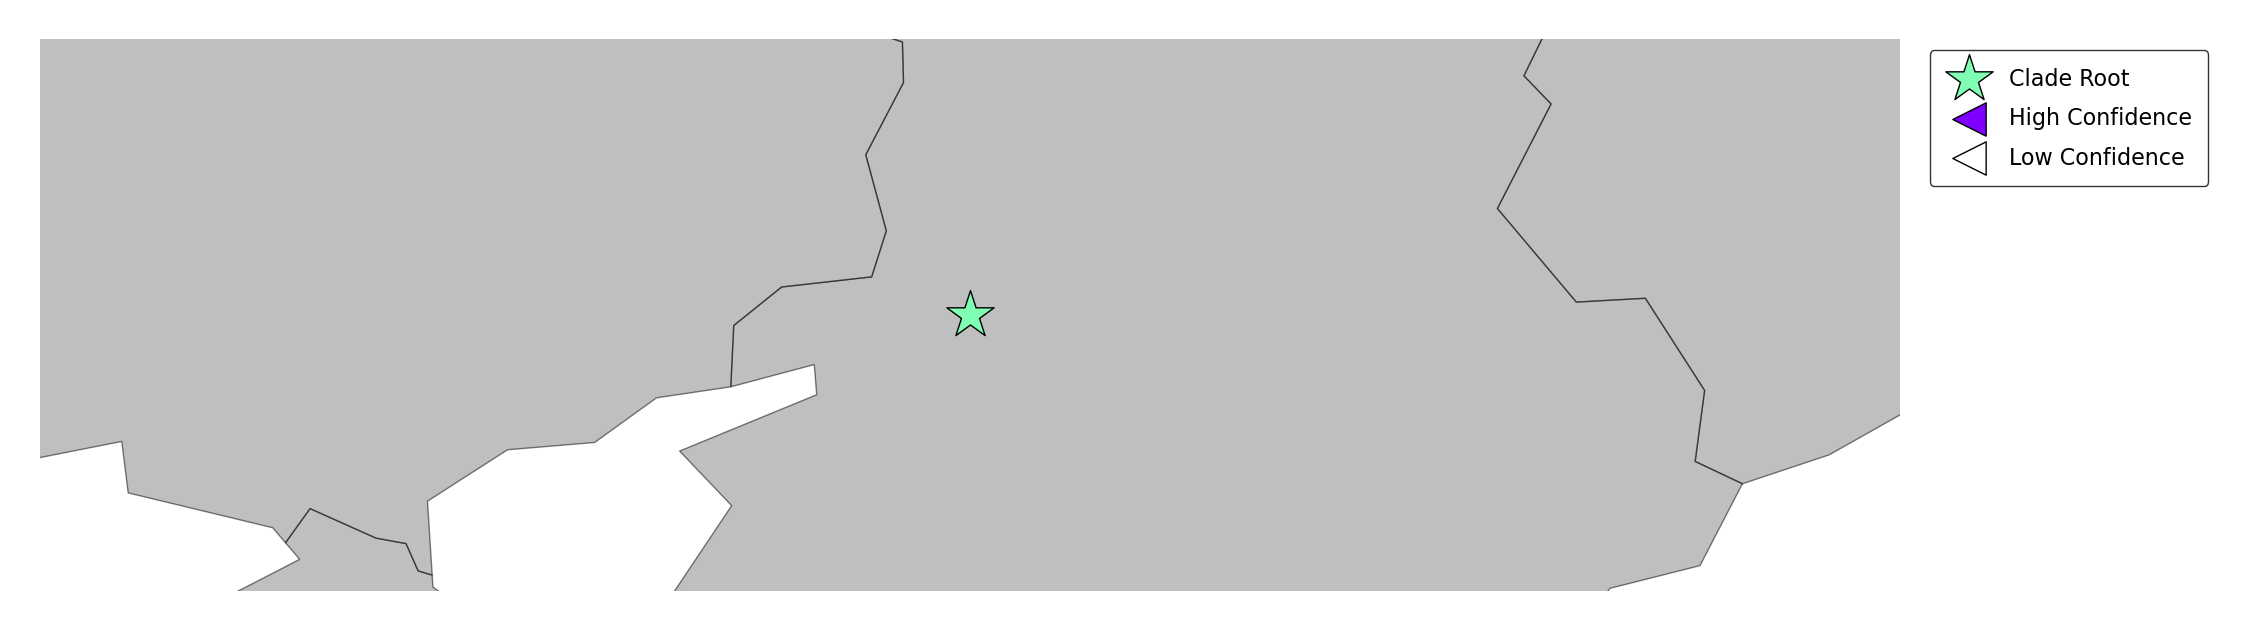

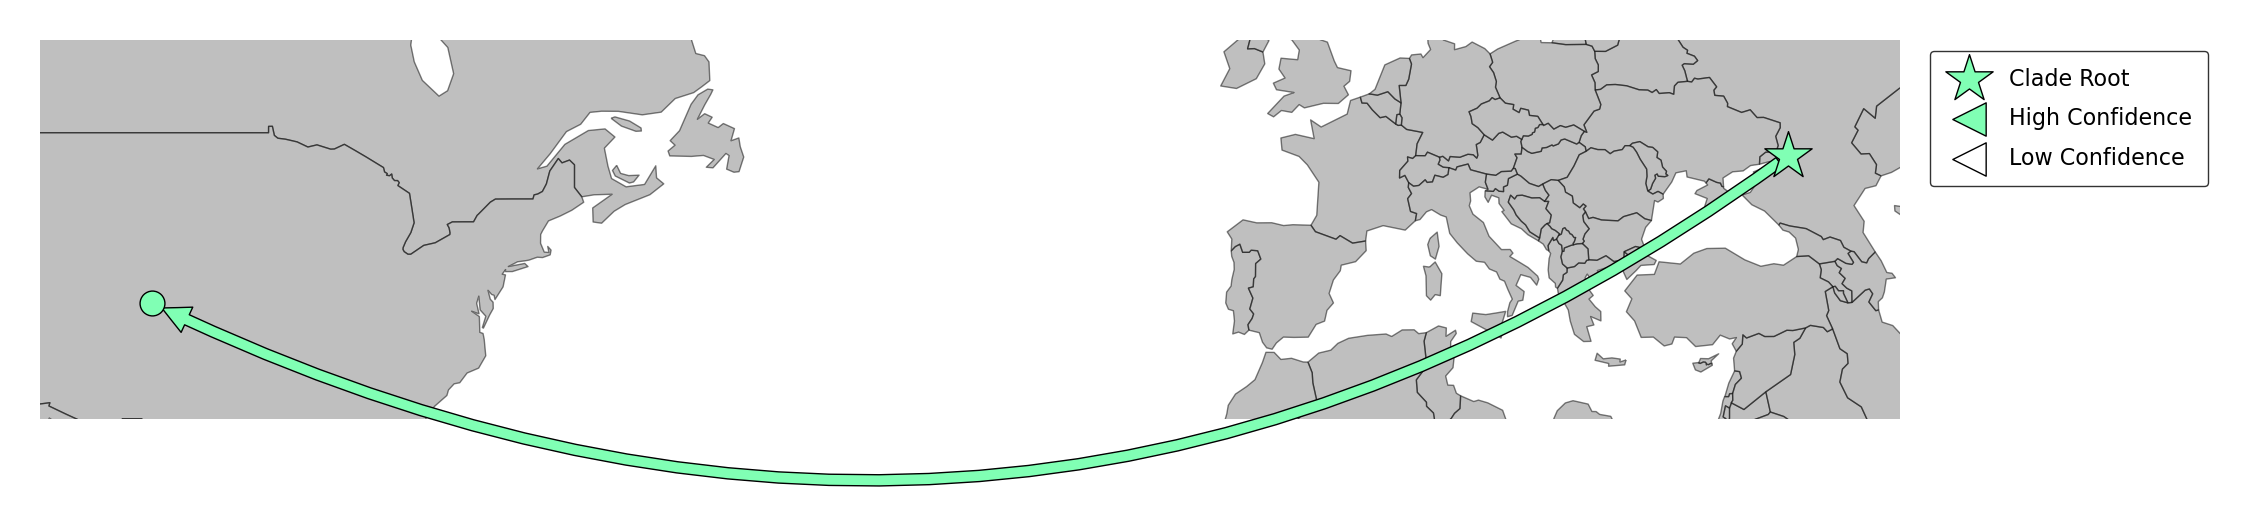

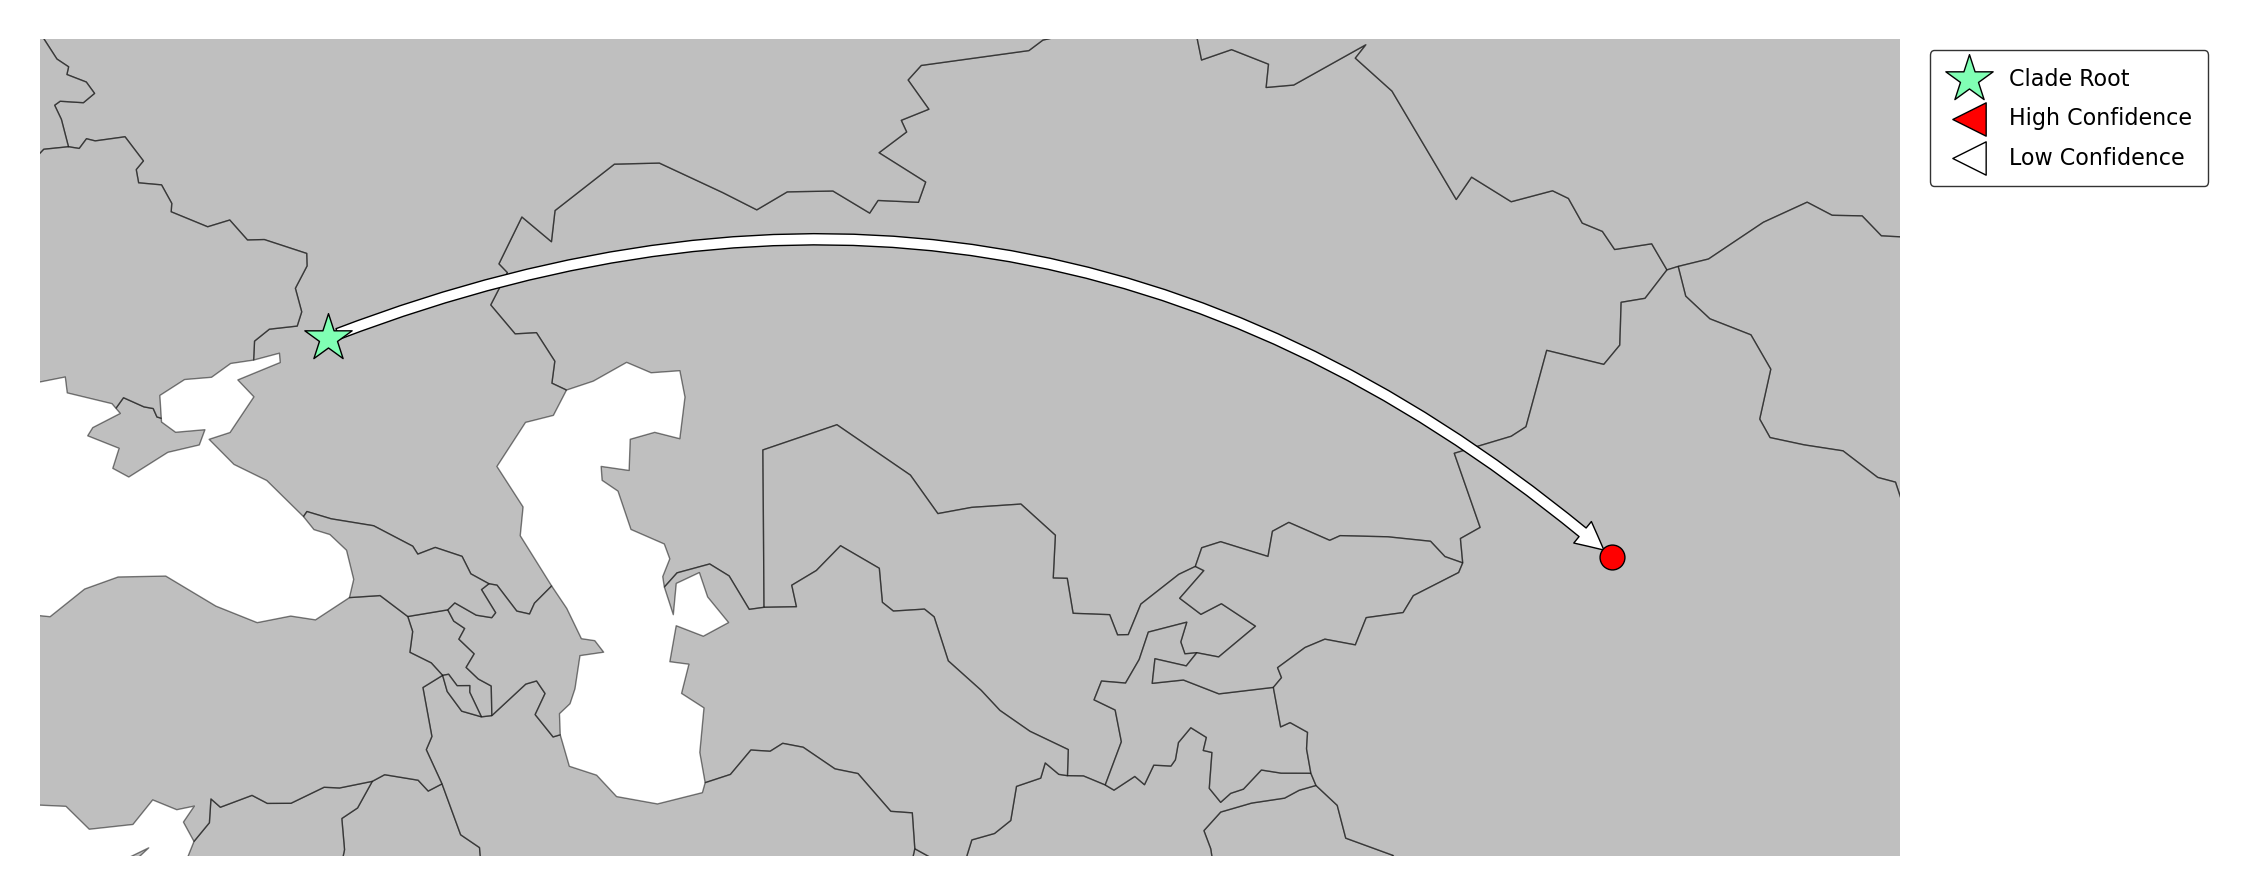

In [13]:
for branch in branch_dict:
    print("Working on branch:", branch)
    #if branch != "4.ANT": continue
    #if "0" not in branch: continue
    fig, ax1 = plt.subplots(1, dpi=dpi, figsize=(6,3))
    # --------------------------------------
    # World Basemap
    world_poly = world_polygons.plot(ax=ax1, 
                        zorder=1, 
                        alpha=0.5, 
                        color="grey",
                        edgecolor="black", 
                        linewidth=0.25,
                       )
    
    gdf = branch_dict[branch]["gdf"]
    tree = branch_dict[branch]["clade"]
    

    # Store node connections
    connect_list = []
    
    # If this subtree excludes the true root, manually add its connections
    if not tree.root.up:
        for c in tree.find_clades():
            if c.up and c.up.name == tree.root.name:
                connect_list.append([tree.root.name, c.name])
    for t in tree.get_terminals():
        # Check for an upper node
        if tree.root.up:
            path = tree.up.get_path(t)
        else:
            path = tree.get_path(t)
            
        for i in range(0, len(path) -1):
            connection = [path[i].name, path[i+1].name]
            # Don't store duplicate connections
            if connection not in connect_list:
                connect_list.append(connection)
    
    # Plot connections
    for connection in connect_list:
        origin = gdf[gdf.index.str.contains(connection[0])]
        dest = gdf[gdf.index.str.contains(connection[1])]
        origin_geom = origin["geometry"][0]
        dest_geom = dest["geometry"][0]
        dest_state = dest["Mugration_Branch_Major"][0]
        dest_color = colors_dict["branch_major"][dest_state]
        arrow_color = "white"
        # Check if using province or country
        geo_attr = "Province"
        if dest["Branch_Support_Color"][0] == TERM_COL:
            if dest["Province"][0] == NO_DATA_CHAR and dest["Country"][0] != "Russia":
                geo_attr = "Country"   
        dest_confidence = dest["Mugration_" + geo_attr + "_Confidence"][0]
        if dest_confidence >= MUG_CONF_THRESH:
            arrow_color = dest_color
        # check if we're changing locations
        if origin_geom != dest_geom:
            # Plot the destination point
            dest.plot(ax=ax1, 
                  color = dest_color,
                  #markersize = sizes_dict[str(dest_geom)],
                  markersize = 20,
                  edgecolor = "black",
                  linewidths=0.25,    
                  zorder=2,
                  )
            # Plot the connection arrow
            ax1.annotate('', xy=(dest_geom.x, dest_geom.y), xytext=(origin_geom.x, origin_geom.y),
                xycoords='data',
                size=10,
                zorder=1,
                label="test",
                arrowprops=dict(facecolor=arrow_color, 
                                ec = 'black', 
                                lw=0.25,
                                arrowstyle="simple",
                                connectionstyle="arc3,rad=-0.3"))

    # Plot root location
    root_gdf = gdf[gdf.index.str.contains(tree.root.name)]
    state = root_gdf["Mugration_Branch_Major"].values[0]
    geom = root_gdf["geometry"].values[0]
    root_gdf.plot(ax=ax1, 
                  color = colors_dict["branch_major"][state],
                  #markersize = sizes_dict[str(geom)],
                  markersize = marker_size * 4,
                  marker = "*",
                  edgecolor = "black",
                  linewidths=0.25,  
                  zorder=2,
                  alpha=1,
                  label="Clade Root"
                  )
    
    
    ax1.scatter(x=1000,y=1000,ec="black", fc=dest_color, marker="<", lw=0.25, label="High Confidence")
    ax1.scatter(x=1000,y=1000,ec="black", fc="white", marker="<", lw=0.25, label="Low Confidence")

    
    # --------------------------------------
    # Limits
    
    # Get xlim from data
    x_min = 300
    x_max = -300
    y_min = 100
    y_max = -100
    range_x_min = 40
    for geom in branch_dict[branch]["gdf"]["geometry"]:
        if geom.x <= x_min:
            x_min = geom.x
        if geom.x > x_max:
            x_max = geom.x
        if geom.y <= y_min:
            y_min = geom.y
        if geom.y > y_max:
            y_max = geom.y
    
    x_buffer = 10
    y_buffer = 2
    
    # Manual adjustments
    if branch == "0.PRE" or branch == "1.ANT" or branch == "0.PE" or branch == "0.ANT" or branch == "1.IN" or branch == "1.ORI":
        y_buffer = 7
    ax1.set_xlim(x_min - x_buffer, x_max + x_buffer)
    ax1.set_ylim(y_min - y_buffer, y_max + y_buffer)

    # --------------------------------------
    # Labels
    ax1.axis('off')
    
    #ax1.set_title(branch, fontsize=SM_FONT)    
    # --------------------------------------
    # Legend
    legend = plt.legend(frameon=True, 
               edgecolor="black", 
               borderpad=0.75, 
               bbox_to_anchor=(1.01, 1), 
               loc='upper left',
               fontsize=4,)
    legend.get_frame().set_linewidth(0.25)  
    out_path = os.path.join(outdir, SCRIPT_NAME + "_spreadmap_{}.{}".format(branch, FMT)) 
    plt.savefig(out_path, dpi=dpi, bbox_inches = "tight")

---
# Export

## Dataframe

In [14]:
out_path_df = os.path.join(outdir, SCRIPT_NAME + ".tsv" )
out_path_pickle_df = os.path.join(outdir,  SCRIPT_NAME + ".df.obj" )

tree_df.to_csv(out_path_df, sep="\t")
with open(out_path_pickle_df,"wb") as outfile:
    dill.dump(tree_df, outfile)